In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import pandas as pd
from pandas import DataFrame as dframe
import cvxpy as cv

In [13]:
def Dic(feat_l_tr,feat_r_tr): #入力の配列は2次元配列である必要がある
    feat_tr = np.concatenate([feat_l_tr, feat_r_tr],0)
    return feat_tr

In [14]:
def SRC(feat_tr_dic,feat_l_te,matrix_index):
    answer = np.zeros(feat_l_te.shape[1])
    SRC_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    SRC_l_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    SRC_r_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    for i in range(feat_l_te.shape[1]):
        x = cv.Variable((feat_tr_dic.shape[1],1)) #目的関数の次元
        objective = cv.Minimize(cv.norm(x,1))
        constraints = [feat_l_te[:,i,np.newaxis] == feat_tr_dic@x]
        prob = cv.Problem(objective, constraints)
        result = prob.solve()
        #classVariableから値を取るためには.valueを付ける
        SRC_Cla[:,i] = np.squeeze(x.value)
        #各クラスに関連する表現ベクトルの値を抜き出す
        #lは仕切りの値
        l = 0
        j = 0
        while j < matrix_index.shape[0]-1:
            SRC_l_Cla[l:l+matrix_index[j],i] = SRC_Cla[l:l+matrix_index[j],i]     
            l = l + matrix_index[j]
            j = j + 1
            SRC_r_Cla[l:l+matrix_index[j],i] = SRC_Cla[l:l+matrix_index[j],i]
            l = l + matrix_index[j]
            j = j + 1
    #パラメータを使って擬似的に各クラスのテスト信号の特徴ベクトルを作成
    dout_feat_l_te = np.zeros((feat_l_te.shape[0], feat_l_te.shape[1]))
    dout_feat_r_te = np.zeros((feat_l_te.shape[0], feat_l_te.shape[1])) 
    for i in range(feat_l_te.shape[1]):
        dout_feat_l_te[:,i] = feat_tr_dic@SRC_l_Cla[:,i]
    for i in range(feat_l_te.shape[1]):
        dout_feat_r_te[:,i] = feat_tr_dic@SRC_r_Cla[:,i]
    #作成した擬似特徴ベクトルとの残差を求める
    R_l =  np.zeros((feat_l_te.shape[0], feat_l_te.shape[1])) #残差を格納するための配列
    R_r =  np.zeros((feat_l_te.shape[0], feat_l_te.shape[1]))  
    for i in range(feat_l_te.shape[1]):
        R_l[:,i] = feat_l_te[:,i]-dout_feat_l_te[:,i]
        R_r[:,i] = feat_l_te[:,i]-dout_feat_r_te[:,i]
        if np.linalg.norm(R_l[:,i], ord=2) < np.linalg.norm(R_r[:,i], ord=2):
            answer[i] = 1
        elif np.linalg.norm(R_l[:,i], ord=2) > np.linalg.norm(R_r[:,i], ord=2):
            answer[i] = 2
    return answer

In [15]:
def SRC_test(filename1,filename2,filename3,filename4,C1_K1,C2_K1,C1_K2,C2_K2,C1_K3,C2_K3):
    #対象被験者の特徴ベクトルをMATLABから入手
    feat_C1 = np.loadtxt(filename1,delimiter=",")
    feat_C2 = np.loadtxt(filename2,delimiter=",")
    feat_Test_C1 = np.loadtxt(filename3,delimiter=",")
    feat_Test_C2 = np.loadtxt(filename4,delimiter=",")
    #非対象被験者の特徴ベクトルをMATLABから入手
    feat_C1_K1 = np.loadtxt(C1_K1,delimiter=",")
    feat_C2_K1 = np.loadtxt(C2_K1,delimiter=",")
    feat_C1_K2 = np.loadtxt(C1_K2,delimiter=",")
    feat_C2_K2 = np.loadtxt(C1_K2,delimiter=",")
    feat_C1_K3 = np.loadtxt(C1_K3,delimiter=",")
    feat_C2_K3 = np.loadtxt(C1_K3,delimiter=",")
    #Tは被験者の試行回数である
    feat_tr = Dic(feat_C1,feat_C2)
    #非対象被験者の特徴ベクトルも同様の処理を行う
    feat_tr_K1 = Dic(feat_C1_K1,feat_C2_K1)
    feat_tr_K2 = Dic(feat_C1_K2,feat_C2_K2)
    feat_tr_K3 = Dic(feat_C1_K3,feat_C2_K3)

    #それぞれの特徴ベクトルをつなげる
    feat_tr_dic_1 = Dic(feat_tr,feat_tr_K1)
    feat_tr_dic_2 = Dic(feat_tr_dic_1,feat_tr_K2)
    feat_tr_dic = Dic(feat_tr_dic_2,feat_tr_K3).T
    #feat_tr_dicはすべての特徴ベクトルをつなげたもの
    #まず、分類に用いるテストデータの特徴ベクトルを2次元に変換
    feat_l_te = feat_Test_C1;
    feat_r_te = feat_Test_C2;
    feat_l_te = feat_l_te.T
    feat_r_te = feat_r_te.T

    matrix_index = np.array([feat_C1.shape[0],feat_C2.shape[0],feat_C1_K1.shape[0],feat_C2_K1.shape[0],feat_C1_K2.shape[0],feat_C2_K2.shape[0],
                        feat_C1_K3.shape[0],feat_C2_K3.shape[0]])
    answer1 = SRC(feat_tr_dic,feat_l_te,matrix_index)
    answer2 = SRC(feat_tr_dic,feat_r_te,matrix_index)
    x1 = 0
    x2 = 0
    for i in range(answer1.shape[0]):
        if answer1[i] == 1:
            x1 = x1 + 1
        if answer2[i] == 2:
            x2 = x2 + 1
    temp = ((x1+x2)/(answer1.shape[0]+answer2.shape[0]))*100
    temp1 = ((x1)/(answer1.shape[0]))*100
    temp2 = ((x2)/(answer2.shape[0]))*100
                    
    return temp,temp1,temp2

In [16]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A01T_20.txt","feat_2a_250Hz_20/feat_right_A01T_20.txt","feat_2a_250Hz_Test/feat_test_left_A01E.txt","feat_2a_250Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A02T_20.txt","feat_2a_250Hz_20/feat_right_A02T_20.txt","feat_2a_250Hz_Test/feat_test_left_A02E.txt","feat_2a_250Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A03T_20.txt","feat_2a_250Hz_20/feat_right_A03T_20.txt","feat_2a_250Hz_Test/feat_test_left_A03E.txt","feat_2a_250Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A07T_20.txt","feat_2a_250Hz_20/feat_right_A07T_20.txt","feat_2a_250Hz_Test/feat_test_left_A07E.txt","feat_2a_250Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A08T_20.txt","feat_2a_250Hz_20/feat_right_A08T_20.txt","feat_2a_250Hz_Test/feat_test_left_A08E.txt","feat_2a_250Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A09T_20.txt","feat_2a_250Hz_20/feat_right_A09T_20.txt","feat_2a_250Hz_Test/feat_test_left_A09E.txt","feat_2a_250Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A08T_30.txt","feat_2a_250Hz_30/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([6, 3])
print(probability_1)

[[ 50.   0. 100.]
 [ 50.   0. 100.]
 [ 58.  38.  78.]
 [ 50. 100.   0.]
 [ 50.   0. 100.]
 [ 49.  86.  12.]]


In [17]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A01T_20.txt","feat_2a_250Hz_20/feat_right_A01T_20.txt","feat_2a_250Hz_Test/feat_test_left_A01E.txt","feat_2a_250Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A02T_20.txt","feat_2a_250Hz_20/feat_right_A02T_20.txt","feat_2a_250Hz_Test/feat_test_left_A02E.txt","feat_2a_250Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A03T_20.txt","feat_2a_250Hz_20/feat_right_A03T_20.txt","feat_2a_250Hz_Test/feat_test_left_A03E.txt","feat_2a_250Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A07T_20.txt","feat_2a_250Hz_20/feat_right_A07T_20.txt","feat_2a_250Hz_Test/feat_test_left_A07E.txt","feat_2a_250Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A08T_20.txt","feat_2a_250Hz_20/feat_right_A08T_20.txt","feat_2a_250Hz_Test/feat_test_left_A08E.txt","feat_2a_250Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A09T_20.txt","feat_2a_250Hz_20/feat_right_A09T_20.txt","feat_2a_250Hz_Test/feat_test_left_A09E.txt","feat_2a_250Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A08T_30.txt","feat_2a_250Hz_30_2/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([6, 3])
print(probability_2)

[[ 51.   4.  98.]
 [ 50.   0. 100.]
 [ 50.  16.  84.]
 [ 52. 100.   4.]
 [ 50.   0. 100.]
 [ 50.   0. 100.]]


In [18]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A01T_20.txt","feat_2a_250Hz_20/feat_right_A01T_20.txt","feat_2a_250Hz_Test/feat_test_left_A01E.txt","feat_2a_250Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A02T_20.txt","feat_2a_250Hz_20/feat_right_A02T_20.txt","feat_2a_250Hz_Test/feat_test_left_A02E.txt","feat_2a_250Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A03T_20.txt","feat_2a_250Hz_20/feat_right_A03T_20.txt","feat_2a_250Hz_Test/feat_test_left_A03E.txt","feat_2a_250Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_30_3/feat_left_A07T_30.txt","feat_2a_250Hz_30_3/feat_right_A07T_30.txt","feat_2a_250Hz_Test/feat_test_left_A07E.txt","feat_2a_250Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A08T_20.txt","feat_2a_250Hz_20/feat_right_A08T_20.txt","feat_2a_250Hz_Test/feat_test_left_A08E.txt","feat_2a_250Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A09T_20.txt","feat_2a_250Hz_20/feat_right_A09T_20.txt","feat_2a_250Hz_Test/feat_test_left_A09E.txt","feat_2a_250Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A08T_30.txt","feat_2a_250Hz_30_3/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([6, 3])
print(probability_3)

[[ 44.  54.  34.]
 [ 50.   0. 100.]
 [ 48.   4.  92.]
 [ 51.  22.  80.]
 [ 44.  74.  14.]
 [ 51. 100.   2.]]


In [19]:
p_average_250Hz = (probability_1+probability_2+probability_3)/3
print(p_average_250Hz)

[[ 48.33333333  19.33333333  77.33333333]
 [ 50.           0.         100.        ]
 [ 52.          19.33333333  84.66666667]
 [ 51.          74.          28.        ]
 [ 48.          24.66666667  71.33333333]
 [ 50.          62.          38.        ]]


In [20]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A01T_20.txt","feat_2a_125Hz_20/feat_right_A01T_20.txt","feat_2a_125Hz_Test/feat_test_left_A01E.txt","feat_2a_125Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A02T_20.txt","feat_2a_125Hz_20/feat_right_A02T_20.txt","feat_2a_125Hz_Test/feat_test_left_A02E.txt","feat_2a_125Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A03T_20.txt","feat_2a_125Hz_20/feat_right_A03T_20.txt","feat_2a_125Hz_Test/feat_test_left_A03E.txt","feat_2a_125Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A07T_20.txt","feat_2a_125Hz_20/feat_right_A07T_20.txt","feat_2a_125Hz_Test/feat_test_left_A07E.txt","feat_2a_125Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A08T_20.txt","feat_2a_125Hz_20/feat_right_A08T_20.txt","feat_2a_125Hz_Test/feat_test_left_A08E.txt","feat_2a_125Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A09T_20.txt","feat_2a_125Hz_20/feat_right_A09T_20.txt","feat_2a_125Hz_Test/feat_test_left_A09E.txt","feat_2a_125Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A08T_30.txt","feat_2a_125Hz_30/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([6, 3])
print(probability_1)

[[ 50. 100.   0.]
 [ 50.   0. 100.]
 [ 50.  70.  30.]
 [ 50.   0. 100.]
 [ 48.  12.  84.]
 [ 56.  80.  32.]]


In [21]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A01T_20.txt","feat_2a_125Hz_20/feat_right_A01T_20.txt","feat_2a_125Hz_Test/feat_test_left_A01E.txt","feat_2a_125Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A02T_30.txt","feat_2a_125Hz_30_2/feat_right_A02T_30.txt","feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A02T_20.txt","feat_2a_125Hz_20/feat_right_A02T_20.txt","feat_2a_125Hz_Test/feat_test_left_A02E.txt","feat_2a_125Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A03T_20.txt","feat_2a_125Hz_20/feat_right_A03T_20.txt","feat_2a_125Hz_Test/feat_test_left_A03E.txt","feat_2a_125Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A02T_30.txt","feat_2a_125Hz_30_2/feat_right_A02T_30.txt","feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A07T_20.txt","feat_2a_125Hz_20/feat_right_A07T_20.txt","feat_2a_125Hz_Test/feat_test_left_A07E.txt","feat_2a_125Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A08T_20.txt","feat_2a_125Hz_20/feat_right_A08T_20.txt","feat_2a_125Hz_Test/feat_test_left_A08E.txt","feat_2a_125Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A09T_20.txt","feat_2a_125Hz_20/feat_right_A09T_20.txt","feat_2a_125Hz_Test/feat_test_left_A09E.txt","feat_2a_125Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A06T_30.txt","feat_2a_125Hz_30_2/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([6, 3])
print(probability_2)

[[ 52.   4. 100.]
 [ 51.  94.   8.]
 [ 58.  36.  80.]
 [ 50.   0. 100.]
 [ 50.   0. 100.]
 [ 53.  42.  64.]]


In [22]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A01T_20.txt","feat_2a_125Hz_20/feat_right_A01T_20.txt","feat_2a_125Hz_Test/feat_test_left_A01E.txt","feat_2a_125Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A02T_30.txt","feat_2a_125Hz_30_3/feat_right_A02T_30.txt","feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A02T_20.txt","feat_2a_125Hz_20/feat_right_A02T_20.txt","feat_2a_125Hz_Test/feat_test_left_A02E.txt","feat_2a_125Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A03T_20.txt","feat_2a_125Hz_20/feat_right_A03T_20.txt","feat_2a_125Hz_Test/feat_test_left_A03E.txt","feat_2a_125Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A02T_30.txt","feat_2a_125Hz_30_3/feat_right_A02T_30.txt","feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A07T_20.txt","feat_2a_125Hz_20/feat_right_A07T_20.txt","feat_2a_125Hz_Test/feat_test_left_A07E.txt","feat_2a_125Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A08T_20.txt","feat_2a_125Hz_20/feat_right_A08T_20.txt","feat_2a_125Hz_Test/feat_test_left_A08E.txt","feat_2a_125Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A09T_20.txt","feat_2a_125Hz_20/feat_right_A09T_20.txt","feat_2a_125Hz_Test/feat_test_left_A09E.txt","feat_2a_125Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A08T_30.txt","feat_2a_125Hz_30_3/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([6, 3])
print(probability_3)

[[ 59.  42.  76.]
 [ 50. 100.   0.]
 [ 51. 100.   2.]
 [ 50.   0. 100.]
 [ 56.  62.  50.]
 [ 49.   8.  90.]]


In [23]:
p_average_125Hz = (probability_1+probability_2+probability_3)/3
print(p_average_125Hz)

[[ 53.66666667  48.66666667  58.66666667]
 [ 50.33333333  64.66666667  36.        ]
 [ 53.          68.66666667  37.33333333]
 [ 50.           0.         100.        ]
 [ 51.33333333  24.66666667  78.        ]
 [ 52.66666667  43.33333333  62.        ]]


In [24]:
a_20 = 0; a_30 = 0;
for i in range(6):
    a_20 = a_20 + p_average_250Hz[i,0] 
    a_30 = a_30 + p_average_125Hz[i,0] 
    
a_20 = a_20/6
a_30 = a_30/6
print(a_20,a_30)

49.88888888888889 51.833333333333336


[[53.66666667 50.33333333 53.         50.         51.33333333 52.66666667]
 [48.33333333 50.         52.         51.         48.         50.        ]]


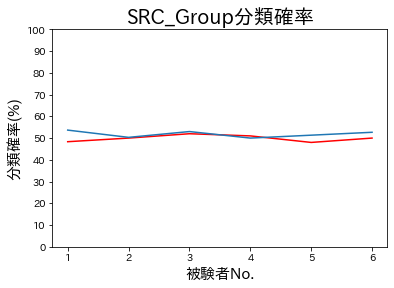

In [25]:
import matplotlib.pyplot as plt
import japanize_matplotlib
y = np.array([])
x = np.arange(1, 7, step=1)
y = np.append(p_average_250Hz[:,0],y)
y = np.append(p_average_125Hz[:,0],y)
y = y.reshape([2,6])
print(y)
plt.plot(x,y[1],"red")
plt.plot(x,y[0])
plt.title("SRC_Group分類確率", {"fontsize":20})
plt.xlabel("被験者No.", {"fontsize":15})
plt.ylabel("分類確率(%)", {"fontsize":15})
plt.xticks(np.arange(1, 7, step=1))
plt.yticks(np.arange(0, 110, step=10))
plt.savefig("2a_SRC_group_probability_K3.pdf")
plt.show()

In [31]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_20/feat_right_aa_20.txt","feat_4a_1000Hz_20/feat_foot_aa_20.txt","feat_4a_1000Hz_Test/feat_test_right_aa.txt","feat_4a_1000Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_1000Hz_30/feat_right_av_30.txt","feat_4a_1000Hz_30/feat_foot_av_30.txt","feat_4a_1000Hz_30/feat_right_al_30.txt","feat_4a_1000Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aw_30.txt","feat_4a_1000Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_20/feat_right_av_20.txt","feat_4a_1000Hz_20/feat_foot_av_20.txt","feat_4a_1000Hz_Test/feat_test_right_av.txt","feat_4a_1000Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aa_30.txt","feat_4a_1000Hz_30/feat_foot_aa_30.txt","feat_4a_1000Hz_30/feat_right_al_30.txt","feat_4a_1000Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aw_30.txt","feat_4a_1000Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_20/feat_right_aw_20.txt","feat_4a_1000Hz_20/feat_foot_aw_20.txt","feat_4a_1000Hz_Test/feat_test_right_aw.txt","feat_4a_1000Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aa_30.txt","feat_4a_1000Hz_30/feat_foot_aa_30.txt","feat_4a_1000Hz_30/feat_right_al_30.txt","feat_4a_1000Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30/feat_right_av_30.txt","feat_4a_1000Hz_30/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([3, 3])
print(probability_1)

[[ 53.  52.  54.]
 [ 50. 100.   0.]
 [ 50.  94.   6.]]


In [32]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_20/feat_right_aa_20.txt","feat_4a_1000Hz_20/feat_foot_aa_20.txt","feat_4a_1000Hz_Test/feat_test_right_aa.txt","feat_4a_1000Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_av_30.txt","feat_4a_1000Hz_30_2/feat_foot_av_30.txt","feat_4a_1000Hz_30_2/feat_right_al_30.txt","feat_4a_1000Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aw_30.txt","feat_4a_1000Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_20/feat_right_av_20.txt","feat_4a_1000Hz_20/feat_foot_av_20.txt","feat_4a_1000Hz_Test/feat_test_right_av.txt","feat_4a_1000Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aa_30.txt","feat_4a_1000Hz_30_2/feat_foot_aa_30.txt","feat_4a_1000Hz_30_2/feat_right_al_30.txt","feat_4a_1000Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aw_30.txt","feat_4a_1000Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_20/feat_right_aw_20.txt","feat_4a_1000Hz_20/feat_foot_aw_20.txt","feat_4a_1000Hz_Test/feat_test_right_aw.txt","feat_4a_1000Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aa_30.txt","feat_4a_1000Hz_30_2/feat_foot_aa_30.txt","feat_4a_1000Hz_30_2/feat_right_al_30.txt","feat_4a_1000Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_av_30.txt","feat_4a_1000Hz_30_2/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([3, 3])
print(probability_2)

[[ 53.  64.  42.]
 [ 49.  42.  56.]
 [ 51. 100.   2.]]


In [33]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_20/feat_right_aa_20.txt","feat_4a_1000Hz_20/feat_foot_aa_20.txt","feat_4a_1000Hz_Test/feat_test_right_aa.txt","feat_4a_1000Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_av_30.txt","feat_4a_1000Hz_30_3/feat_foot_av_30.txt","feat_4a_1000Hz_30_3/feat_right_al_30.txt","feat_4a_1000Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aw_30.txt","feat_4a_1000Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_20/feat_right_av_20.txt","feat_4a_1000Hz_20/feat_foot_av_20.txt","feat_4a_1000Hz_Test/feat_test_right_av.txt","feat_4a_1000Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aa_30.txt","feat_4a_1000Hz_30_3/feat_foot_aa_30.txt","feat_4a_1000Hz_30_3/feat_right_al_30.txt","feat_4a_1000Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aw_30.txt","feat_4a_1000Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_20/feat_right_aw_20.txt","feat_4a_1000Hz_20/feat_foot_aw_20.txt","feat_4a_1000Hz_Test/feat_test_right_aw.txt","feat_4a_1000Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aa_30.txt","feat_4a_1000Hz_30_3/feat_foot_aa_30.txt","feat_4a_1000Hz_30_3/feat_right_al_30.txt","feat_4a_1000Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_av_30.txt","feat_4a_1000Hz_30_3/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([3, 3])
print(probability_3)

[[53. 60. 46.]
 [48. 20. 76.]
 [47. 24. 70.]]


In [34]:
p_average_1000Hz = (probability_1+probability_2+probability_3)/3
print(p_average_1000Hz)

[[53.         58.66666667 47.33333333]
 [49.         54.         44.        ]
 [49.33333333 72.66666667 26.        ]]


In [35]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_4a_100Hz_20/feat_right_aa_20.txt","feat_4a_100Hz_20/feat_foot_aa_20.txt","feat_4a_100Hz_Test/feat_test_right_aa.txt","feat_4a_100Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_100Hz_30/feat_right_av_30.txt","feat_4a_100Hz_30/feat_foot_av_30.txt","feat_4a_100Hz_30/feat_right_al_30.txt","feat_4a_100Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30/feat_right_aw_30.txt","feat_4a_100Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_100Hz_20/feat_right_av_20.txt","feat_4a_100Hz_20/feat_foot_av_20.txt","feat_4a_100Hz_Test/feat_test_right_av.txt","feat_4a_100Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_100Hz_30/feat_right_aa_30.txt","feat_4a_100Hz_30/feat_foot_aa_30.txt","feat_4a_100Hz_30/feat_right_al_30.txt","feat_4a_100Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30/feat_right_aw_30.txt","feat_4a_100Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_100Hz_20/feat_right_aw_20.txt","feat_4a_100Hz_20/feat_foot_aw_20.txt","feat_4a_100Hz_Test/feat_test_right_aw.txt","feat_4a_100Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_100Hz_30/feat_right_aa_30.txt","feat_4a_100Hz_30/feat_foot_aa_30.txt","feat_4a_100Hz_30/feat_right_al_30.txt","feat_4a_100Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30/feat_right_av_30.txt","feat_4a_100Hz_30/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([3, 3])
print(probability_1)

[[ 50.   0. 100.]
 [ 50.   0. 100.]
 [ 56.  16.  96.]]


In [46]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_4a_100Hz_20/feat_right_aa_20.txt","feat_4a_100Hz_20/feat_foot_aa_20.txt","feat_4a_100Hz_Test/feat_test_right_aa.txt","feat_4a_100Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_av_30.txt","feat_4a_100Hz_30_2/feat_foot_av_30.txt","feat_4a_100Hz_30_2/feat_right_al_30.txt","feat_4a_100Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aw_30.txt","feat_4a_100Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_100Hz_20/feat_right_av_20.txt","feat_4a_100Hz_20/feat_foot_av_20.txt","feat_4a_100Hz_Test/feat_test_right_av.txt","feat_4a_100Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aa_30.txt","feat_4a_100Hz_30_2/feat_foot_aa_30.txt","feat_4a_100Hz_30_2/feat_right_al_30.txt","feat_4a_100Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aw_30.txt","feat_4a_100Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_100Hz_20/feat_right_aw_20.txt","feat_4a_100Hz_20/feat_foot_aw_20.txt","feat_4a_100Hz_Test/feat_test_right_aw.txt","feat_4a_100Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aa_30.txt","feat_4a_100Hz_30_2/feat_foot_aa_30.txt","feat_4a_100Hz_30_2/feat_right_al_30.txt","feat_4a_100Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_av_30.txt","feat_4a_100Hz_30_2/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([3, 3])
print(probability_2)

[[ 50.   0. 100.]
 [ 50. 100.   0.]
 [ 54.  68.  40.]]


In [47]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_4a_100Hz_20/feat_right_aa_20.txt","feat_4a_100Hz_20/feat_foot_aa_20.txt","feat_4a_100Hz_Test/feat_test_right_aa.txt","feat_4a_100Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_av_30.txt","feat_4a_100Hz_30_3/feat_foot_av_30.txt","feat_4a_100Hz_30_3/feat_right_al_30.txt","feat_4a_100Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aw_30.txt","feat_4a_100Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_100Hz_20/feat_right_av_20.txt","feat_4a_100Hz_20/feat_foot_av_20.txt","feat_4a_100Hz_Test/feat_test_right_av.txt","feat_4a_100Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aa_30.txt","feat_4a_100Hz_30_3/feat_foot_aa_30.txt","feat_4a_100Hz_30_3/feat_right_al_30.txt","feat_4a_100Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aw_30.txt","feat_4a_100Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_100Hz_20/feat_right_aw_20.txt","feat_4a_100Hz_20/feat_foot_aw_20.txt","feat_4a_100Hz_Test/feat_test_right_aw.txt","feat_4a_100Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aa_30.txt","feat_4a_100Hz_30_3/feat_foot_aa_30.txt","feat_4a_100Hz_30_3/feat_right_al_30.txt","feat_4a_100Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_av_30.txt","feat_4a_100Hz_30_3/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([3, 3])
print(probability_3)

[[ 50.   0. 100.]
 [ 51.  12.  90.]
 [ 46.   0.  92.]]


In [48]:
p_average_100Hz = (probability_1+probability_2+probability_3)/3
print(p_average_100Hz)

[[ 50.           0.         100.        ]
 [ 50.33333333  37.33333333  63.33333333]
 [ 52.          28.          76.        ]]


In [49]:
a_20 = 0; a_30 = 0;
for i in range(3):
    a_20 = a_20 + p_average_1000Hz[i,0] 
    a_30 = a_30 + p_average_100Hz[i,0] 
    
a_20 = a_20/3
a_30 = a_30/3
print(a_20,a_30)

50.44444444444445 50.77777777777778


[[50.         50.33333333 52.        ]
 [53.         49.         49.33333333]]


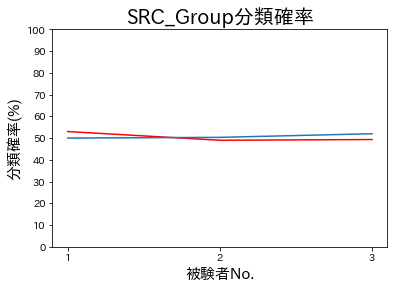

In [50]:
import matplotlib.pyplot as plt
import japanize_matplotlib
y = np.array([])
x = np.arange(1, 4, step=1)
y = np.append(p_average_1000Hz[:,0],y)
y = np.append(p_average_100Hz[:,0],y)
y = y.reshape([2,3])
print(y)
plt.plot(x,y[1],"red")
plt.plot(x,y[0])
plt.title("SRC_Group分類確率", {"fontsize":20})
plt.xlabel("被験者No.", {"fontsize":15})
plt.ylabel("分類確率(%)", {"fontsize":15})
plt.xticks(np.arange(1, 4, step=1))
plt.yticks(np.arange(0, 110, step=10))
plt.savefig("4a_SRC_group_probability_K3.pdf")
plt.show()